In [426]:
from torch import nn
import torch
import pickle 
import json
from torch.optim.swa_utils import AveragedModel, SWALR
from lshiftml.feature_utils.parallel import get_features_in_parallel
from rascal.representations import SphericalInvariants as SOAP
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from skcosmo.preprocessing import StandardFlexibleScaler
import numpy as np
import ase

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import joblib
import time


In [384]:
from sklearn.metrics import mean_absolute_error

In [336]:
class NeuralNetwork(nn.Module):
    def __init__(self,n_hidden,activation,num_input):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        #This is the pretrained_RELU stack
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_input,n_hidden),
            nn.LayerNorm(n_hidden),
            activation(),
            nn.Linear(n_hidden,1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class NeuralNetwork_bak(nn.Module):
    def __init__(self,l1):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Linear(num_input, l1),
            nn.LayerNorm(l1),
            nn.ReLU(),
            nn.Linear(l1,1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def NN_factory(**kwargs):
    #this is necessary because pytorch changes the layer state dict keys when using averaged models
    torch.set_default_tensor_type(torch.DoubleTensor)
    model = NeuralNetwork(**kwargs)
    return AveragedModel(model)
    
    

class ShiftMLNN:
    
    DEFAULT_MODEL_PATH = {"v1":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v1/large_model_{}_{}_float64_opt.pth",
                         "v2":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v2/large_model_{}_{}_float64_opt.pth"}
    DEFAULT_FEATURE_SCALER_PATH = {"v1":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v1/scaler_features_{}_model_no_{}_float64_opt.pkl",
                                  "v2":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v2/scaler_features_{}_model_no_{}_float64_opt.pkl"}
    DEFAULT_LABEL_SCALER_PATH = {"v1":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v1/scaler_labels_{}_model_no_{}_float64_opt.pkl",
                                  "v2":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v2/scaler_labels_{}_model_no_{}_float64_opt.pkl"
                                }
    DEFAULT_HYPERS_PATH = {"v1":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v1/{}_hypers.json","v2":"/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/NN_model_data/NN_v2/{}_hypers.json"}
    
    default_architecture_dict = {"v2":{1:{"n_hidden":512,"activation":nn.Softplus,"num_input":3780},
                                 6:{"n_hidden":256, "activation":nn.Tanh,"num_input":3780},
                                 7:{"n_hidden":16,"activation":nn.Softplus,"num_input":3780},
                                 8:{"n_hidden":512,"activation":nn.Tanh,"num_input":3780}},
                                 "v1":{1:{"n_hidden":256,"activation":nn.ReLU,"num_input":60},
                                      6:{"n_hidden":512,"activation":nn.ReLU,"num_input":60},
                                      7:{"n_hidden":1024,"activation":nn.ReLU,"num_input":60},
                                      8:{"n_hidden":512,"activation":nn.ReLU,"num_input":60}
                                }}
    
    def __init__(self,trained_for=[1,6,7,8],defined_for=[1,6,7,8,16],bodyorder="v1",model_architecture=NN_factory,architecture_dict=None,n_models=16,MODEL_PATH=None \
                 ,FEATURE_SCALER_PATH=None, LABEL_SCALER_PATH=None,HYPERS_PATH=None):
        
        """initializes model by loading state dicts,
           initializing pytorch model objects 
           and loading skcosmo flexible scalers
           
           bodyorder hyperparameter is ignored when choosing own architecture
        """
        
        self.species = trained_for
        self.defined = defined_for
        self.label_scalers = {k:[] for k in trained_for}
        self.feature_scalers = {k:[] for k in trained_for}
        #self.feature_means
        #self.feature_vars
        self.models = {k:[] for k in trained_for}
        self.hypers = {k:None for k in trained_for}
        
        self._MODEL_PATH = self.DEFAULT_MODEL_PATH[bodyorder] if MODEL_PATH is None else MODEL_PATH
        self._FEATURE_SCALER_PATH = self.DEFAULT_FEATURE_SCALER_PATH[bodyorder] if FEATURE_SCALER_PATH is None else FEATURE_SCALER_PATH
        self._LABEL_SCALER_PATH = self.DEFAULT_LABEL_SCALER_PATH[bodyorder] if LABEL_SCALER_PATH is None else LABEL_SCALER_PATH
        self._HYPERS_PATH = self.DEFAULT_HYPERS_PATH[bodyorder] if HYPERS_PATH is None else HYPERS_PATH
        
        #this is incredibly stupid and I should have never done that
        self._architecture_dict = self.default_architecture_dict[bodyorder] if architecture_dict is None else architecture_dict
        
        for specie in trained_for:
            
            with open(self._HYPERS_PATH.format(specie),"r") as fg:
                hypers = json.load(fg)
            
            self.hypers[specie] = hypers
            
            for n in range(n_models):
                
                model = model_architecture(**self._architecture_dict[specie])
                state_dict = torch.load(self._MODEL_PATH.format(specie,n),map_location ='cpu')
                model.load_state_dict(state_dict)
                self.models[specie].append(model)
                
                #this is crap. replace by json?
                with open(self._FEATURE_SCALER_PATH.format(specie,n),"rb") as fg:
                    feature_scaler = pickle.load(fg)
                with open(self._LABEL_SCALER_PATH.format(specie,n),"rb") as fg:    
                    label_scaler = pickle.load(fg)
                    
                self.feature_scalers[specie].append(feature_scaler)
                self.label_scalers[specie].append(label_scaler)
        
    
    def predict(self,frames,predict_for=None,output="average"):
        
        #assuming wrapped frames
        results = {}
        atomic_numbers = []
        
        is_single_frame = isinstance(frames,ase.atoms.Atoms)
        
        if is_single_frame:
            atomic_numbers = frames.numbers
        else:
            for frame in frames:
                atomic_numbers.append(frame.numbers)
            
        
        atomic_numbers = np.hstack(atomic_numbers)
        atomic_species = np.unique(atomic_numbers)
        
        for specie in atomic_species:
            if specie not in self.defined:
                raise NotImplementedError("Model not defined for specie {}".format(specie))            
        
        if predict_for is None:
            predict_for = self.species
            
        for specie in predict_for:
            if specie not in self.species:
                raise NotImplementedError("Model not trained for specie {}".format(specie))
        
        
        
        #avoids completely masked frames for rascal

            
        predict_for = np.intersect1d(atomic_species,predict_for)
        predict_for = [int(specie) for specie in predict_for]
                    
        for specie in predict_for:
            if is_single_frame:
                frames.arrays.pop("center_atoms_mask",None)
                mask_center_atoms_by_species(frames,species_select=[specie])
            else:
                for frame in frames: 
                    frame.arrays.pop("center_atoms_mask",None)
                    mask_center_atoms_by_species(frame,species_select=[specie])
            

            if is_single_frame: 
                soap = SOAP(**self.hypers[specie])
                Xpredict = soap.transform(frames).get_features(soap)
            else:
                Xpredict = get_features_in_parallel(frames,SOAP,self.hypers[specie])
            predictions = []
            
            for model,feature_scaler,label_scaler in \
                zip(self.models[specie],self.feature_scalers[specie],self.label_scalers[specie]):
                
                #TODO: does the scaler also work on tensors?

                Xpredict_scaled = feature_scaler.transform(Xpredict)
                
                #costs O(N): https://stsievert.com/blog/2017/09/07/pytorch/
                Xpredict_scaled = torch.from_numpy(Xpredict_scaled)

                with torch.no_grad(): #13 sec
                    Y_predict = model(Xpredict_scaled)

                Y_predict_inverse_rescaled = label_scaler.inverse_transform(Y_predict.numpy().reshape(-1,1))

                
                predictions.append(Y_predict_inverse_rescaled)
            
            results[specie] = np.hstack(predictions)
            
            if output == "average":
                average = np.mean(results[specie],axis=1)
                variance = np.var(results[specie],axis=1)
                results[specie] = np.vstack([average,variance]).T
            elif output == "raw":
                continue
            else:
                raise NotImplementedError
                
            #quick test to check whether copying in scaler worked
            #print(np.allclose(Xpredict,get_features_in_parallel(frames,SOAP,self.hypers[specie])))
        
        return results
        #gen feat
        
        #scale feat
        #if scaling is False: skip
        #
        #inverse_scale predictions
        #if inverse_scale is false: skip
        #
        #check option, return full predictions or average and variance
        #return framewise, or full ?
        

                
                
                
                
            
        

In [447]:
class ShiftMLRR:
    
    DEFAULT_MODEL_PATH = {"v1":"/ssd/scratch/kellner/COSMO_project/uncertainty/multi_ridge_v1/specie_{}_model_no_{}_name_clf",
                         "v2":"/ssd/scratch/kellner/COSMO_project/uncertainty/multi_ridge_v2/{}_{}_name_clf"}
    DEFAULT_HYPERS_PATH = {"v1":"/ssd/scratch/kellner/COSMO_project/uncertainty/multi_ridge_v1/specie_{}_model_no_0_hypers.json","v2":"/ssd/scratch/kellner/COSMO_project/uncertainty/multi_ridge_v2/{}_0_hypers.json"}
    
    
    def __init__(self,trained_for=[1,6,7,8],defined_for=[1,6,7,8,16],bodyorder="v1",n_models=16,MODEL_PATH=None \
                 ,HYPERS_PATH=None):
        
        """initializes model by loading sklearn models,
           bodyorder hyperparameter is ignored when choosing own architecture
        """
        
        self.species = trained_for
        self.defined = defined_for

        self.models = {k:[] for k in trained_for}
        self.hypers = {k:None for k in trained_for}
        
        self._MODEL_PATH = self.DEFAULT_MODEL_PATH[bodyorder] if MODEL_PATH is None else MODEL_PATH
        self._HYPERS_PATH = self.DEFAULT_HYPERS_PATH[bodyorder] if HYPERS_PATH is None else HYPERS_PATH
        
        
        for specie in trained_for:
            
            with open(self._HYPERS_PATH.format(specie),"r") as fg:
                hypers = json.load(fg)
            
            self.hypers[specie] = hypers
            
            for n in range(n_models):
                model = joblib.load(self._MODEL_PATH.format(specie,n))
                self.models[specie].append(model)
        
    
    def predict(self,frames,predict_for=None,output="average"):
        
        #assuming wrapped frames
        results = {}
        atomic_numbers = []
        
        is_single_frame = isinstance(frames,ase.atoms.Atoms)
        
        if is_single_frame:
            atomic_numbers = frames.numbers
        else:
            for frame in frames:
                atomic_numbers.append(frame.numbers)
            
        
        atomic_numbers = np.hstack(atomic_numbers)
        atomic_species = np.unique(atomic_numbers)
        
        for specie in atomic_species:
            if specie not in self.defined:
                raise NotImplementedError("Model not defined for specie {}".format(specie))            
        
        if predict_for is None:
            predict_for = self.species
            
        for specie in predict_for:
            if specie not in self.species:
                raise NotImplementedError("Model not trained for specie {}".format(specie))
        
        
        
        #avoids completely masked frames for rascal

            
        predict_for = np.intersect1d(atomic_species,predict_for)
        predict_for = [int(specie) for specie in predict_for]
                    
        for specie in predict_for:
            if is_single_frame:
                frames.arrays.pop("center_atoms_mask",None)
                mask_center_atoms_by_species(frames,species_select=[specie])
            else:
                for frame in frames: 
                    frame.arrays.pop("center_atoms_mask",None)
                    mask_center_atoms_by_species(frame,species_select=[specie])
            

            if is_single_frame: 
                soap = SOAP(**self.hypers[specie])
                Xpredict = soap.transform(frames).get_features(soap)
            else:
                Xpredict = get_features_in_parallel(frames,SOAP,self.hypers[specie])
            predictions = []
            
            for model in self.models[specie]:
                
                Y_predict = model.predict(Xpredict)
                predictions.append(Y_predict)
            
            results[specie] = np.vstack(predictions).T
            
            print(results[specie].shape)
            if output == "average":
                average = np.mean(results[specie],axis=1)
                variance = np.var(results[specie],axis=1)
                results[specie] = np.vstack([average,variance]).T
            elif output == "raw":
                continue
            else:
                raise NotImplementedError
                
            #quick test to check whether copying in scaler worked
            #print(np.allclose(Xpredict,get_features_in_parallel(frames,SOAP,self.hypers[specie])))
        
        return results
        #gen feat
        
        #scale feat
        #if scaling is False: skip
        #
        #inverse_scale predictions
        #if inverse_scale is false: skip
        #
        #check option, return full predictions or average and variance
        #return framewise, or full ?

In [464]:
combined = ShiftMLRR(bodyorder="v1")

In [465]:
out = combined.predict(frames)

(35289, 16)
(31446, 16)
(3367, 16)
(6346, 16)


In [461]:
#frames = read("../../make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",index=":",format="extxyz")
frames = read("../../../COSMO_project/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",index=":",format="extxyz")
tmp = []

for frame in frames:
    numbers = np.unique(frame.numbers)
    
    defined = True
    for number in numbers:
        if number not in [1,6,7,8,16]:
            defined = False
        else:
            continue
    
    if defined:
        tmp.append(frame)

frames = tmp
        
results = {}
for specie in [1,6,7,8]:
    tmp = []
    for frame in frames:
        mask_center_atoms_by_species(frame,species_select=[specie])
        tmp.append(frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]])
        del frame.arrays["center_atoms_mask"]
    results[specie] = np.hstack(tmp)   
for frame in frames: frame.wrap(eps=1e-12)

In [450]:
out[1].shape

(37656, 2)

In [295]:
import cProfile

In [282]:
cProfile.run("combined.predict(frames)")

         479318 function calls (471685 primitive calls) in 43.148 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.168    0.168   43.148   43.148 1806068984.py:115(predict)
       64    0.000    0.000   13.269    0.207 1806068984.py:14(forward)
        1    0.000    0.000    0.000    0.000 1806068984.py:149(<listcomp>)
        5    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_1d)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
       14    0.000    0.000    0.488    0.035 <__array_function__ internals>:2(concatenate)
        5    0.000    0.000    0.008    0.002 <__array_function__ internals>:2(hstack)
     4776    0.002    0.000    0.033    0.000 <__array_function__ internals>:2(in1d)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(intersect1d)
     4776    0.002    0.000    0.075    0.000 <__array_function_

In [467]:
for specie in [1,6,7,8]:
    print(mean_squared_error(out[specie][:,0],results[specie],squared=False))

1.2157128969044495
9.267273088469878
36.39220933978026
52.414795798181224


In [321]:
combined = ShiftMLNN(bodyorder="v2")

In [319]:
out = combined.predict(frames)

--- transform 9.963484048843384 seconds-----
---torch 13.166052103042603 seconds ---
---feat 9.179221868515015 seconds ---
---structure loops 0.1090242862701416 seconds ---
---inverse 0.007536172866821289 seconds ---


In [275]:
out[6].shape

(31446, 2)

In [371]:
combined = ShiftMLNN(bodyorder="v2")
#out = combined.predict(frames)


In [433]:
out = combined.predict(frames)

AxisError: axis 1 is out of bounds for array of dimension 1

In [379]:
out[specie][:,0].shape

(101512,)

In [452]:
for specie in [1,6,7,8]:
    print(mean_squared_error(out[specie][:,0],results[specie],squared=False))

4.730138955385111
18.465306167014948
53.848914359413676
82.30760589322293


In [375]:
import matplotlib.pyplot as plt

In [391]:
specie = 6
np.abs(mean_squared_error(out[specie][:,0],results[specie],squared=False))

32.01831426327777

In [398]:
np.max(np.abs(out[specie][:,0]-results[specie]))

5514.088532382175

In [399]:
np.abs(mean_squared_error(out[specie][:,0],results[specie],squared=False))

32.01831426327777

In [400]:
np.mean(results[specie])

63.72290580901381

In [413]:
with open("6_hypers.json","r") as fg:
    hypers = json.load(fg)

In [421]:
hypers["global_species"] = [ 1,  6,  7,  8,  9, 11, 12, 15, 16, 17, 19, 20, 35, 53]

In [422]:
soap = SOAP(**hypers)
Xpredict = soap.transform(frames[0]).get_features(soap)

In [424]:
Xpredict.shape

(92, 26460)

In [392]:
mean_absolute_error(out[specie][:,0],results[specie])

3.38015334431056

In [406]:
np.sum(np.abs(out[specie][:,0]-results[specie])>80)

78

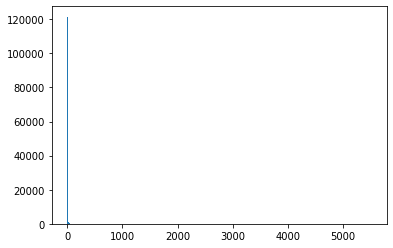

In [401]:
specie = 6
_ = plt.hist(np.abs(out[specie][:,0]-results[specie]),bins=300)

In [383]:
np.max(np.abs(out[specie][:,0]-results[specie]))

119.76909048612231

In [351]:
len(frames)

659

In [407]:
frames = read("../../../COSMO_project/Shiftml2/CSD-10k_fps_training_relax_w_shifts.xyz",index=":",format="extxyz")
tmp = []

for frame in frames:
    tmp.append(frame.numbers)

In [ ]:
len(frames

In [412]:
14**2/5**2

7.84

In [420]:
np.unique(np.hstack(tmp))

array([ 1,  6,  7,  8,  9, 11, 12, 15, 16, 17, 19, 20, 35, 53])

In [411]:
len(np.unique(np.hstack(tmp)))

14

In [388]:
len(frames)

4060

In [370]:
frames[1030].numbers

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  7,  7,  7,  7,  7,
        7,  7,  7,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  6,  6,
        6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  6,  6,  6,  6,  1,  1,  1,
        1,  1,  1,  1,  1,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        1,  1,  1,  1,  1,  1,  1,  1,  6,  6,  6,  6,  1,  1,  1,  1,  1,
        1,  1,  1,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  6,  6,
        6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  6,  6,  6,  6,  6,  6,  6,
        6])

In [254]:
with open("./scaler_features_8_model_no_0_float64_opt.pkl","rb") as fg:
    scaler = pickle.load(fg)

In [284]:
scaler.

array([1.95668486e-06, 7.10006291e-07, 7.21640096e-07, ...,
       3.47400628e-10, 3.83742881e-10, 3.92947223e-10])

In [258]:
scaler.transform(torch.ones(100,3780))

array([[46581.38230758, 46581.4403797 , 46581.43983779, ...,
        46581.47343666, 46581.47343497, 46581.47343454],
       [46581.38230758, 46581.4403797 , 46581.43983779, ...,
        46581.47343666, 46581.47343497, 46581.47343454],
       [46581.38230758, 46581.4403797 , 46581.43983779, ...,
        46581.47343666, 46581.47343497, 46581.47343454],
       ...,
       [46581.38230758, 46581.4403797 , 46581.43983779, ...,
        46581.47343666, 46581.47343497, 46581.47343454],
       [46581.38230758, 46581.4403797 , 46581.43983779, ...,
        46581.47343666, 46581.47343497, 46581.47343454],
       [46581.38230758, 46581.4403797 , 46581.43983779, ...,
        46581.47343666, 46581.47343497, 46581.47343454]])

(184,)


In [154]:
np.intersect1d([1,7,8,9],[7,8,16])

array([7, 8])

In [230]:
isinstance(frames[0],ase.atoms.Atoms)

True

In [222]:
a = type(frames[0])

In [224]:
type(a)

type

In [147]:
from matplotlib import pyplot as plt

(array([  192.,   240.,   580.,   647.,  1936., 16768., 15437., 18662.,
        30156.,  6550.]),
 array([11.96196233, 13.9296232 , 15.89728406, 17.86494493, 19.83260579,
        21.80026666, 23.76792752, 25.73558838, 27.70324925, 29.67091011,
        31.63857098]),
 <BarContainer object of 10 artists>)

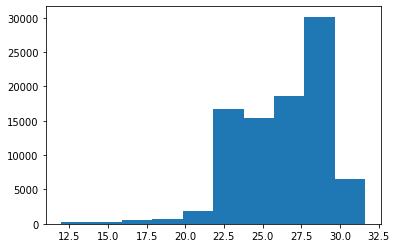

In [149]:
plt.hist(out[1])

In [203]:
len(frames)

597

In [181]:
from sklearn.metrics import mean_squared_error

0.7693687672065885
5.766577975730453
16.0914214643406
20.395912127559154


In [115]:
from ase.io import read

NameError: name 'atomic_number' is not defined

In [108]:
for a,b,c, in zip(range(0,9),range(0,9),range(0,9)): print(a,b,c)

0 0 0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8


In [59]:
model = NeuralNetwork(n_hidden=16,activation=nn.ReLU,num_input=60)

In [60]:
a = torch.load("../multi_NN_v2/large_model_7_13_float64_opt.pth",map_location=torch.device('cpu'))
b = {k.replace("module.",""):v for k,v in a.items()}

In [52]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 1.0723e-01,  1.2103e-02,  9.1022e-02,  1.0258e-01, -5.1082e-02,
                       -9.6621e-02,  1.4879e-02,  1.2175e-01, -3.4338e-02,  1.2814e-01,
                       -8.8985e-02, -1.9065e-02,  1.2659e-01,  7.8106e-02, -2.1368e-02,
                       -1.2447e-02, -3.9047e-02, -1.1719e-01,  2.6314e-02, -4.9876e-02,
                       -9.2950e-02,  6.7280e-02,  1.2637e-01,  1.2506e-01,  6.3418e-02,
                       -6.3661e-03, -1.0385e-01, -1.2544e-01, -2.7939e-02, -1.0927e-01,
                        5.7022e-03,  5.9898e-02, -9.7526e-02, -9.5788e-02, -4.5331e-02,
                       -1.1749e-01, -6.7836e-02,  6.3891e-02,  2.0629e-02,  5.7682e-02,
                        7.1627e-02, -1.0821e-01, -2.2727e-02,  5.6475e-02,  1.2592e-02,
                       -6.0763e-02,  4.4625e-02, -3.7383e-02, -1.0055e-01,  1.0618e-01,
                       -2.2717e-02,  8.1898e-02, -9.2159e-02, -1.0431e-02, -

In [67]:
a.items()

odict_items([('n_averaged', tensor(49)), ('module.linear_relu_stack.0.weight', tensor([[ 9.4920e-03,  6.7218e-03,  5.2324e-03,  ..., -3.6216e-02,
          9.1493e-03, -2.2433e-02],
        [-2.7310e-03,  1.0898e-02,  7.3623e-03,  ...,  4.8998e-02,
          3.4605e-02,  6.2091e-02],
        [ 2.4966e-03, -2.6011e-03,  1.2573e-02,  ..., -6.4834e-02,
         -1.1924e-02, -3.8306e-02],
        ...,
        [ 8.0831e-03, -7.2475e-03, -3.0723e-03,  ...,  1.9825e-03,
         -1.2995e-02,  1.4359e-02],
        [ 7.9673e-03, -3.2430e-05,  1.1558e-02,  ..., -6.4105e-02,
         -2.6581e-02, -3.4876e-02],
        [-5.1869e-03, -2.2085e-02, -1.7314e-02,  ...,  1.3046e-02,
         -1.5962e-04, -2.5373e-02]], dtype=torch.float64)), ('module.linear_relu_stack.0.bias', tensor([ 0.0042,  0.0054,  0.0016, -0.0095,  0.0019, -0.0018, -0.0069,  0.0025,
         0.0030,  0.0062,  0.0041,  0.0057,  0.0048, -0.0014,  0.0071, -0.0036],
       dtype=torch.float64)), ('module.linear_relu_stack.1.weight', t

In [75]:
from copy import copy

In [80]:
"module.lstrip".replace("module.","")

'lstrip'

In [82]:
model.load_state_dict(b)

RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	Unexpected key(s) in state_dict: "n_averaged". 
	size mismatch for linear_relu_stack.0.weight: copying a param with shape torch.Size([16, 3780]) from checkpoint, the shape in current model is torch.Size([16, 60]).

In [41]:
pwd

'/ssd/scratch/kellner/COSMO_project/uncertainty/multi_NN_v2'